In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score  
from wordcloud import WordCloud 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier 
import pickle
import re


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jana\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Load the data
data = pd.read_csv(r'sentiment_analysis/Data/amazon_alexa.tsv', delimiter = '\t', quoting=3) 

print(f"Dataset Shape : {data.shape}")

Dataset Shape : (3150, 5)


In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
# coloumns in the dataset

print(f"Features names : {data.columns.values}")

Features names : ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [5]:
# Check for null values

data.isnull().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
# Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isna() == True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:
# Drop the null values

data.dropna(inplace = True)

In [8]:
print(f"Dataset Shape after dropping null values : {data.shape}")

Dataset Shape after dropping null values : (3149, 5)


In [9]:
# Creating a new column 'length' which contains the length of the string in the 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# One-hot encode the 'variation' column
data_encoded = pd.get_dummies(data, columns=['variation'])

# Convert 'verified_reviews' to numerical data using CountVectorizer
vectorizer = CountVectorizer()
X_reviews = vectorizer.fit_transform(data_encoded['verified_reviews'])

# Combine the vectorized reviews with the other features
X_other = data_encoded.drop(['feedback', 'date', 'verified_reviews'], axis=1)
X = pd.concat([pd.DataFrame(X_reviews.toarray()), X_other.reset_index(drop=True)], axis=1)

# Convert all column names to strings
X.columns = X.columns.astype(str)

y = data_encoded['feedback']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new balance
print(y_train_resampled.value_counts())

feedback
1    2326
0    2326
Name: count, dtype: int64


In [12]:
# Randomly checking for 10th record

print(f"'verified_reviews' colomn valaue : {data.iloc[10]['verified_reviews']}") # Original review
print(f"Length of review : {len(data.iloc[10]['verified_reviews'])}") # Length of the review
print(f"Length column value : {data.iloc[10]['length']}") # Length column value

'verified_reviews' colomn valaue : "I sent it to my 85 year old Dad, and he talks to it constantly."
Length of review : 65
Length column value : 65


In [13]:
data.dtypes

rating               int64
date                object
variation           object
verified_reviews    object
feedback             int64
length               int64
dtype: object

In [14]:
len(data)

3149






Analysing "rating" colomn

In [15]:
# Disttinct values in the 'rating' and its count

print(f"Rating value count : \n{data['rating'].value_counts()}")

Rating value count : 
rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64


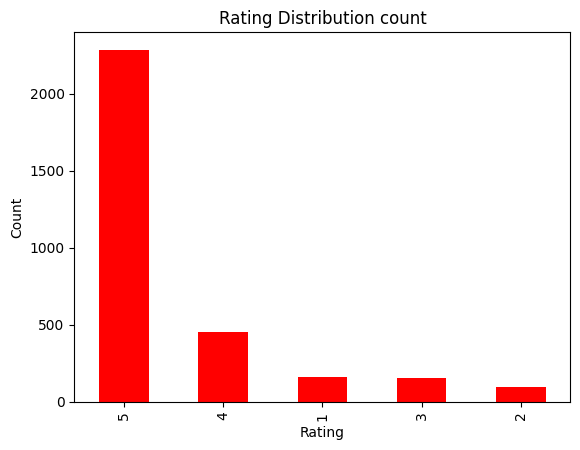

In [16]:
# Bar plot for the 'rating' column

data['rating'].value_counts().plot.bar(color='red')
plt.title('Rating Distribution count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
# Finding the percentage distribution of the 'rating' column - we'll divide the number of records for each rating by the total number of records

print(f"Rating percentage distribution : \n{round(data['rating'].value_counts()/data.shape[0] * 100, 2)}")

Rating percentage distribution : 
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


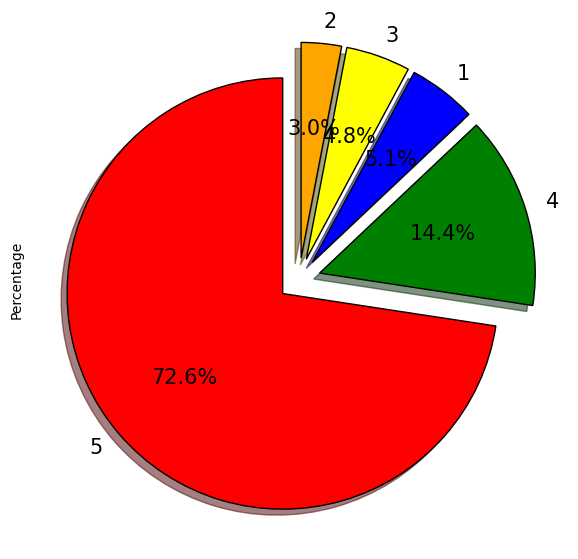

In [18]:
fig = plt.figure(figsize=(7,7))

colors = ['red', 'green', 'blue', 'yellow', 'orange']

wp = { 'linewidth' : 1, 'edgecolor' : "black" }

tags = data['rating'].value_counts() / data.shape[0]

# Get the number of categories in the 'tags' series
num_categories = len(tags)

# Adjust 'explode' to have the same number of elements as categories
# For example, if there are 4 categories, 'explode' should have 4 values
explode = (0.1,) * num_categories

# Create the pie chart without the 'kind' argument
tags.plot.pie(autopct='%1.1f%%', colors=colors[:num_categories], explode=explode, shadow=True, wedgeprops=wp, startangle=90, label='Percentage', fontsize=15)

from io import BytesIO

graph = BytesIO()

# Save the figure to the BytesIO object
fig.savefig(graph, format='png')


In [19]:
# Distinct values in the 'feedback' and its count

print(f"Feedback value count : \n{data['feedback'].value_counts()}")

Feedback value count : 
feedback
1    2893
0     256
Name: count, dtype: int64


In [20]:
# Extracting the 'verified_reviews' values where 'feedback' is 0

review_0 = data[data['feedback'] == 0].iloc[1]['verified_reviews']
print(review_0)

Sound is terrible if u want good music too get a bose


In [21]:
# Extracting the 'verified_reviews' values where 'feedback' is 1

review_1 = data[data['feedback'] == 1].iloc[1]['verified_reviews']
print(review_1)

Loved it!


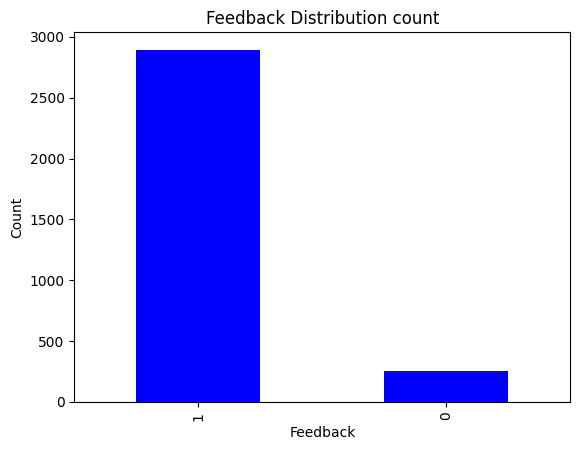

In [22]:
# Bar graph to visualize the total count of each feedbacks

data['feedback'].value_counts().plot.bar(color='blue')
plt.title('Feedback Distribution count')
plt.xlabel('Feedback')  
plt.ylabel('Count')
plt.show()

In [23]:
# Finding the percentage distribution of the 'feedback' column - we'll divide the number of records for each feedback by the total number of records

print(f"Feedback percentage distribution : \n{round(data['feedback'].value_counts()/data.shape[0] * 100, 2)}")

Feedback percentage distribution : 
feedback
1    91.87
0     8.13
Name: count, dtype: float64


<Axes: ylabel='Percentage'>

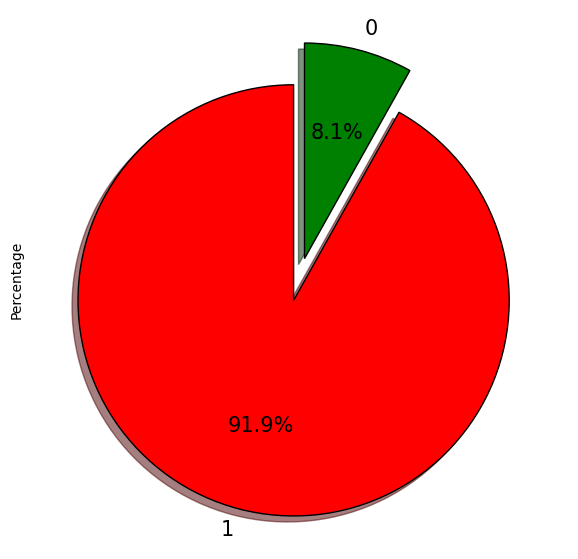

In [24]:
fig = plt.figure(figsize=(7,7))

colors = ['red', 'green']

wp = { 'linewidth' : 1, 'edgecolor' : "black" }

tags = data['feedback'].value_counts() / data.shape[0]

# Get the number of categories in the 'tags' series
num_categories = len(tags)

# Adjust 'explode' to have the same number of elements as categories
# For example, if there are 4 categories, 'explode' should have 4 values
explode = (0.1,0.1)

# Create the pie chart without the 'kind' argument
tags.plot.pie(autopct='%1.1f%%', colors=colors[:num_categories], explode=explode, shadow=True, wedgeprops=wp, startangle=90, label='Percentage', fontsize=15)

In [25]:
# Feedback = 0

data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [26]:
# Feedback = 1

data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

Analyzing 'variation' colomn

In [27]:
# Distinct values in the 'variation' and its count

print(f"Variation value count : \n{data['variation'].value_counts()}")

Variation value count : 
variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64


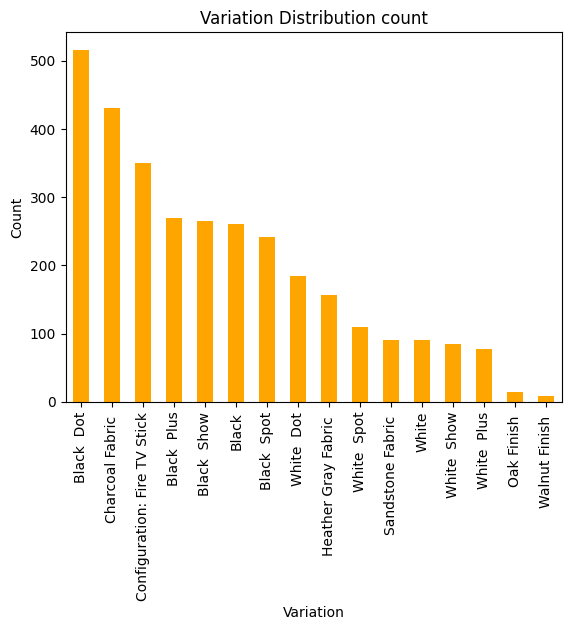

In [28]:
# Bar graph to visualize the total count of each variation

data['variation'].value_counts().plot.bar(color='orange')   
plt.title('Variation Distribution count')
plt.xlabel('Variation')
plt.ylabel('Count') 
plt.show()

In [29]:
# Finding the percentage distribution of the 'variation' column - we'll divide the number of records for each variation by the total number of records

print(f"Variation percentage distribution : \n{round(data['variation'].value_counts()/data.shape[0] * 100, 2)}")

Variation percentage distribution : 
variation
Black  Dot                      16.39
Charcoal Fabric                 13.66
Configuration: Fire TV Stick    11.11
Black  Plus                      8.57
Black  Show                      8.42
Black                            8.29
Black  Spot                      7.65
White  Dot                       5.84
Heather Gray Fabric              4.99
White  Spot                      3.46
Sandstone Fabric                 2.86
White                            2.86
White  Show                      2.70
White  Plus                      2.48
Oak Finish                       0.44
Walnut Finish                    0.29
Name: count, dtype: float64


In [30]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

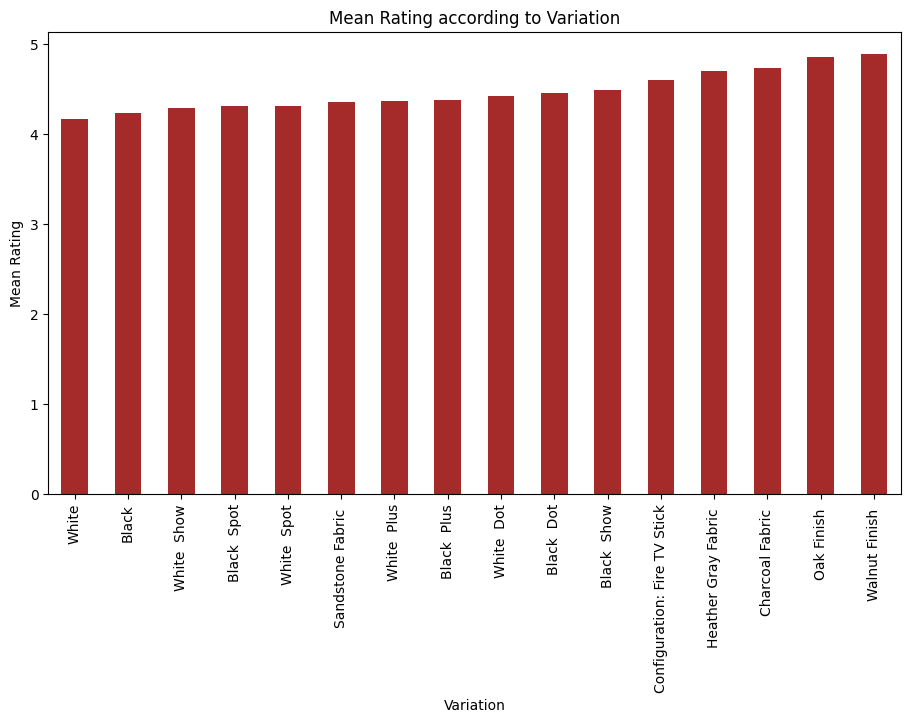

In [31]:
data.groupby('variation')['rating'].mean().sort_values().plot.bar(color='brown', figsize=(11,6))
plt.title('Mean Rating according to Variation')
plt.xlabel('Variation')
plt.ylabel('Mean Rating')
plt.show()    

Analyzing "verified_reviews" colomn

In [32]:
data['length'].describe()

count    3149.000000
mean      132.714513
std       182.541531
min         1.000000
25%        30.000000
50%        74.000000
75%       166.000000
max      2853.000000
Name: length, dtype: float64

[Text(0.5, 1.0, 'Length Distribution of Reviews')]

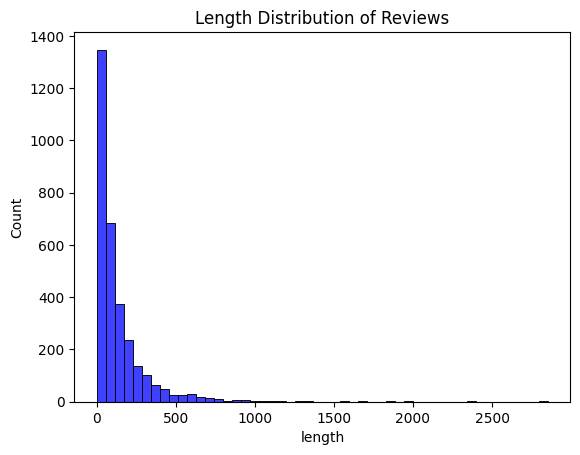

In [33]:
sns.histplot(data['length'], bins=50, color='blue').set(title='Length Distribution of Reviews')

[Text(0.5, 1.0, 'Length Distribution of Reviews with Feedback = 0')]

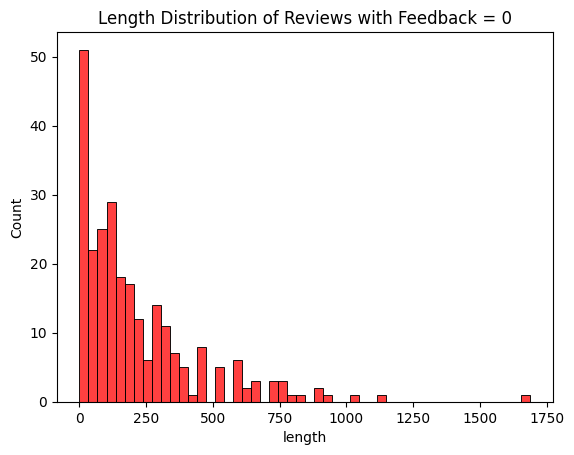

In [34]:
sns.histplot(data[data['feedback'] == 0]['length'], bins=50, color='red').set(title='Length Distribution of Reviews with Feedback = 0')

[Text(0.5, 1.0, 'Length Distribution of Reviews with Feedback = 1')]

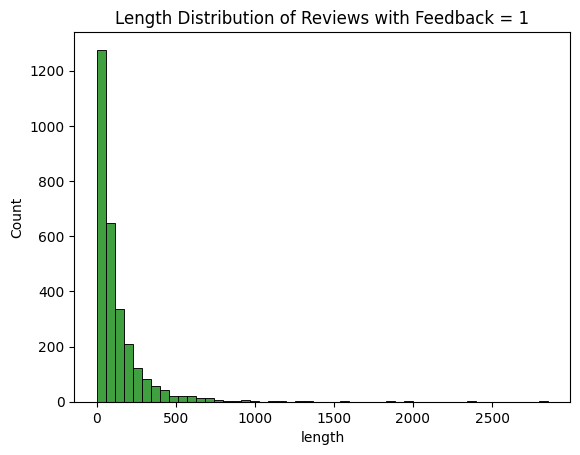

In [35]:
sns.histplot(data[data['feedback'] == 1]['length'], bins=50, color='green').set(title='Length Distribution of Reviews with Feedback = 1')

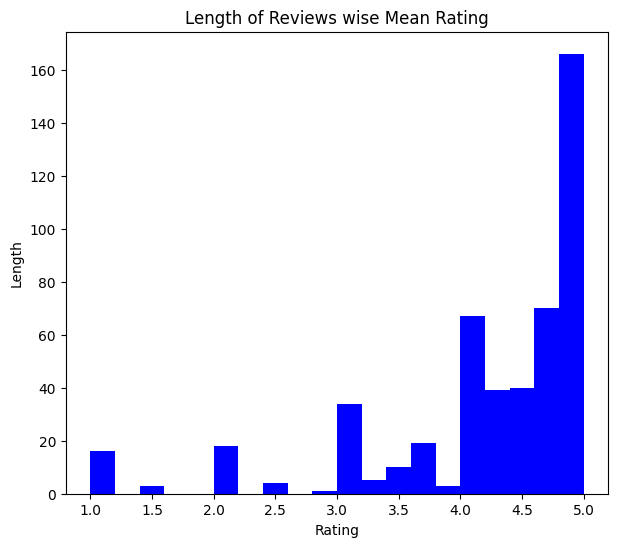

In [36]:
data.groupby('length')['rating'].mean().plot.hist(color='blue', figsize=(7,6), bins=20)
plt.title('Length of Reviews wise Mean Rating')
plt.xlabel('Rating')
plt.ylabel('Length')
plt.show()

In [37]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

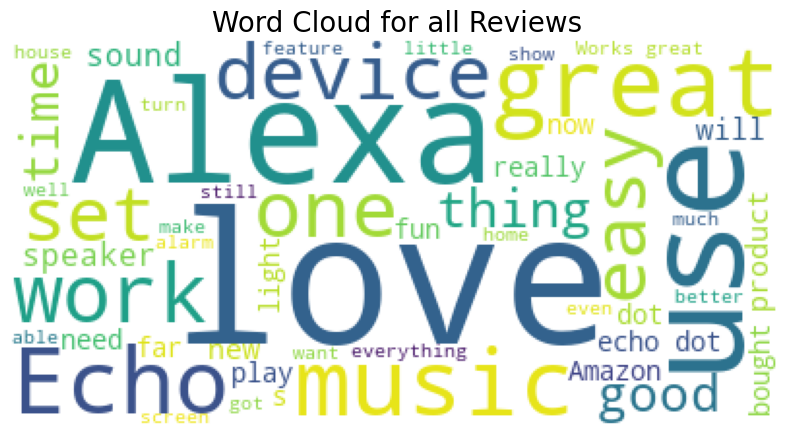

In [38]:
# Combine all reviews
reviews = " ".join([review for review in data['verified_reviews']])

# Initialize wordcount object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Word Cloud for all Reviews', fontsize=20)
plt.axis('off')
plt.show()

In [39]:
# Combine all reviews for each feedback category and split them into individual words
neg_reviews = " ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])
pos_reviews = pos_reviews.lower().split()

# Finding words from reviews whicha are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)

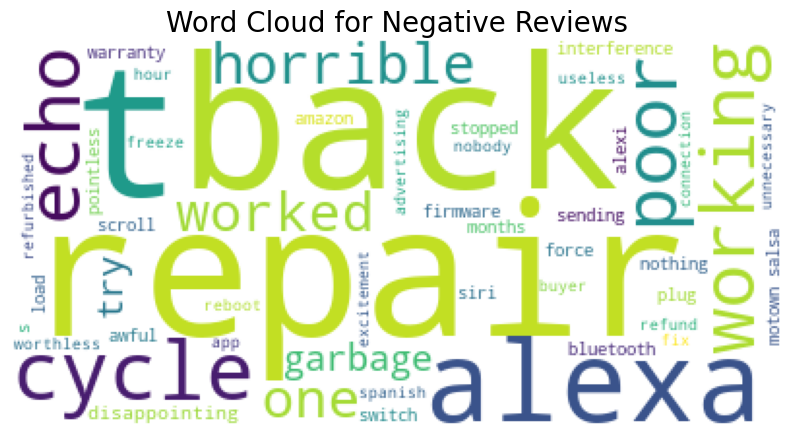

In [40]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Word Cloud for Negative Reviews', fontsize=20)
plt.axis('off')
plt.show()

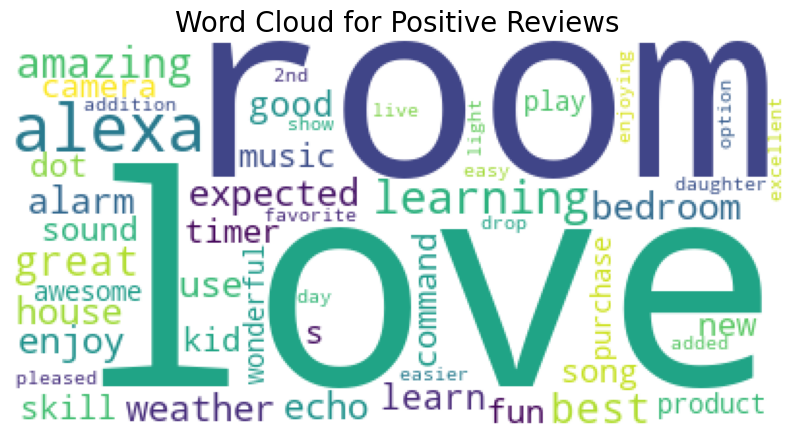

In [41]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot word cloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Word Cloud for Positive Reviews', fontsize=20)
plt.axis('off') 
plt.show()

Proprocessing and Modelling

In [42]:
corpus = []
steammer = PorterStemmer()
for i in range(0, data.shape[0]):
    review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
    review = review.lower().split()
    review = [steammer.stem(word) for word in review if not word in STOPWORDS]
    review = ' '.join(review)
    corpus.append(review)

In [43]:
cv = CountVectorizer(max_features=2500)

# Storing the independent and dependent variable
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [44]:
# Saving the CountVectorizer object
pickle.dump(cv, open('sentiment_analysis/Models/countVectorizer.pkl', 'wb'))

In [45]:
print(f"X Shape : {X.shape}")
print(f"y Shape : {y.shape}")

X Shape : (3149, 2500)
y Shape : (3149,)


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

print(f"X_train Shape : {X_train.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"X_test Shape : {X_test.shape}")
print(f"y_test Shape : {y_test.shape}")

X_train Shape : (2204, 2500)
y_train Shape : (2204,)
X_test Shape : (945, 2500)
y_test Shape : (945,)


In [47]:
print(f"X train max value : {X_train.max()}")
print(f"X train max value : {X_test.max()}")

X train max value : 12
X train max value : 10


In [48]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [49]:
# Saving the scaler model
pickle.dump(scaler, open('sentiment_analysis/Models/scaler.pkl', 'wb'))

In [50]:
# Fitting scaled X_train and y_train on Random Forest Classifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [51]:
# Accuracy of the model on the training and testing data

print("Training Accuracy : ", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy : ", model_rf.score(X_test_scl, y_test))

pickle.dump(model_rf, open('sentiment_analysis/Models/model_rf.pkl', 'wb'))

Training Accuracy :  0.9941016333938294
Testing Accuracy :  0.944973544973545


In [52]:
# Predicting on the test data set

y_pred = model_rf.predict(X_test_scl)

In [53]:
# Confusion matrix

cm = confusion_matrix(y_test, y_pred)

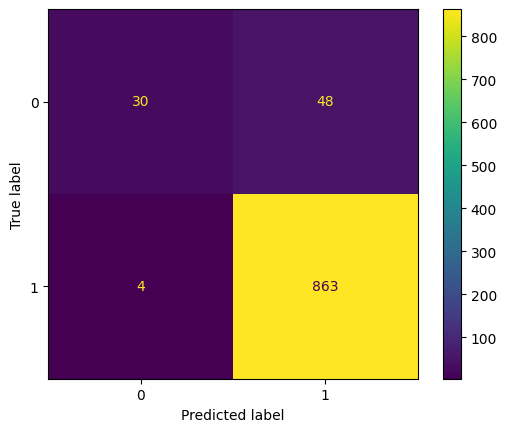

In [54]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K foid cross-validation

In [55]:
accuracies = cross_val_score(estimator=model_rf, X=X_train_scl, y=y_train, cv=10)

print("Accuracy :", accuracies.mean())
print("Standard Deviation :", accuracies.std())

Accuracy : 0.931489099136158
Standard Deviation : 0.007707141705392256


In [56]:
params = {
    'bootstrap' : [True],
    'max_depth' : [80, 100],
    'min_samples_leaf' : [8, 12],
    'n_estimators' : [100, 300]
}

In [57]:
cv_object = StratifiedKFold(n_splits=2)

grid_search = GridSearchCV(estimator=model_rf, param_grid=params, cv=cv_object, verbose=0, return_train_score=True)
grid_search.fit(X_train_scl, y_train.ravel())

GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_leaf': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [58]:
# Getting the best parameters from the grid search

print("Best Parameters Combination : {}", format(grid_search.best_params_))

Best Parameters Combination : {} {'bootstrap': True, 'max_depth': 80, 'min_samples_leaf': 8, 'n_estimators': 100}


In [59]:
print("Cross Validation mean accuracy on training set : {}", format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross Validation mean accuracy on test set : {}", format(grid_search.cv_results_['mean_test_score'].mean()*100))


from sklearn.metrics import accuracy_score

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_preds = best_model.predict(X_test_scl)

print("Accuracy score on test set : ", accuracy_score(y_test, y_preds))

Cross Validation mean accuracy on training set : {} 91.92377495462794
Cross Validation mean accuracy on test set : {} 91.92377495462794
Accuracy score on test set :  0.9174603174603174


XgBoost

In [60]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [61]:
# Accuracy of the model on the training and testing data

print("Training Accuracy : ", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy : ", model_xgb.score(X_test_scl, y_test))

Training Accuracy :  0.9718693284936479
Testing Accuracy :  0.9375661375661376


In [62]:
y_preds = model_xgb.predict(X_test_scl)

In [63]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 30  48]
 [ 11 856]]


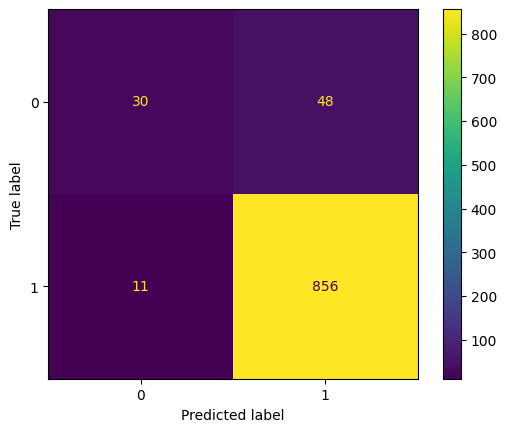

In [64]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [65]:
# Saving the XGBoost model classifier
pickle.dump(model_xgb, open('sentiment_analysis/Models/model_xgb.pkl', 'wb'))

Decision Tree Classifier

In [66]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [67]:
# Accuracy of the model on the training and testing data

print("Training Accuracy : ", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy : ", model_dt.score(X_test_scl, y_test))

pickle.dump(model_dt, open('sentiment_analysis/Models/model_dt.pkl', 'wb'))

Training Accuracy :  0.9941016333938294
Testing Accuracy :  0.9185185185185185


In [68]:
y_preds = model_dt.predict(X_test_scl)

In [69]:
# Confusion matrix

cm = confusion_matrix(y_test, y_preds)
print(cm)

[[ 47  31]
 [ 46 821]]


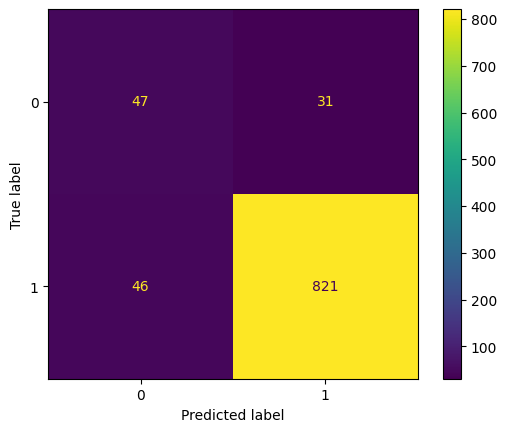

In [70]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_dt.classes_)
cm_display.plot()
plt.show()